# 4) Phrase Diversity (n-gram TTR)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

## Overview
- Measure phrase diversity using **Type–Token Ratio (TTR)** for **bigrams** and **trigrams**.
- Compare lexical variety across two works by the same author (Leo Tolstoy).
- (Optional) Analyze diversity trends across sections/chapters within the texts.

## Learning objectives
- Understand and compute TTR as a measure of lexical/phrasal diversity.
- Apply TTR to n-grams (bigrams, trigrams) to quantify phrase variety.
- Interpret TTR values: lower TTR suggests formulaic/repetitive phrasing, higher TTR indicates more varied expression.
- Produce reproducible diversity metrics and visualizations for literary analysis.

## Quick start
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books (already set to Tolstoy).
2. (Optional) Toggle `use_stopwords` to exclude common function words.
3. Run cells from top to bottom. The main outputs are saved to `results/`.
4. (Optional) Customize section-splitting regex to analyze diversity by chapter.

## Prerequisites
- A Python environment with packages: `pandas`, `matplotlib`.
- The text files for the two works placed in `data/`.


## 0. Setup & Configuration
Fill the `CONFIG` paths for your two books (plain text). Toggle stopwords as needed.

In [4]:
# ===== Imports & Config =====
import re, os, json
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "data/War-and-Peace.txt",     # <-- Tolstoy, English translation
    "book2_path": "data/Anna-Karenina.txt",     # <-- Tolstoy, English translation
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,           # toggle
    "min_ngram_count": 5,             # threshold (unused here but kept for parity)
    "top_k": 20                       # top items to show (unused here but kept for parity)
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


## 1. Load & Normalize Text
- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are from Project Gutenberg; we strip the boilerplate.

In [5]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants sometimes inverted
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Chapters (heuristic fallback if markers missing; English-centric but works often)
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    t = text.replace("\ufeff", "")
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break
    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            end_idx = m.start()
            break
    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)
    core = re.sub(r"\n{3,}", "\n\n", core)
    return core.strip()


In [8]:
def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    t = strip_gutenberg(t)
    t = re.sub(r"-\s*\n", "", t)
    t = re.sub(r"\s+", " ", t)
    return t

# ✅ Correct relative paths (go up one level to /data)
text1 = normalize_text(load_text("../data/War-and-Peace.txt"))
text2 = normalize_text(load_text("../data/Anna-Karenina.txt"))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

tokens = tokens1 + tokens2
len(tokens1), len(tokens2), len(tokens), tokens[:12]


(571345,
 356730,
 928075,
 ['cover',
  'war',
  'and',
  'peace',
  'by',
  'leo',
  'tolstoy',
  'tolstoi',
  'contents',
  'book',
  'one',
  'chapter'])

## 2. Compute TTR for Bigrams & Trigrams
TTR for n-grams measures phrase variety: `unique n-grams / total n-grams`.

In [9]:
def ttr(seq):
    return len(set(seq)) / max(1, len(seq))

bigrams_list = list(zip(tokens, tokens[1:]))
trigrams_list = list(zip(tokens, tokens[1:], tokens[2:]))

ttr2_combined = ttr(bigrams_list)
ttr3_combined = ttr(trigrams_list)

bigrams_list_1 = list(zip(tokens1, tokens1[1:]))
trigrams_list_1 = list(zip(tokens1, tokens1[1:], tokens1[2:]))
ttr2_book1 = ttr(bigrams_list_1)
ttr3_book1 = ttr(trigrams_list_1)

bigrams_list_2 = list(zip(tokens2, tokens2[1:]))
trigrams_list_2 = list(zip(tokens2, tokens2[1:], tokens2[2:]))
ttr2_book2 = ttr(bigrams_list_2)
ttr3_book2 = ttr(trigrams_list_2)

summary_df = pd.DataFrame({
    "metric": ["bigram_TTR", "trigram_TTR"],
    "combined": [ttr2_combined, ttr3_combined],
    "book1": [ttr2_book1, ttr3_book1],
    "book2": [ttr2_book2, ttr3_book2]
})
summary_df


,metric,combined,book1,book2
0,bigram_TTR,0.301930,0.347694,0.354216
1,trigram_TTR,0.711488,0.755275,0.755859


## 2.1 Visualize TTR Comparison

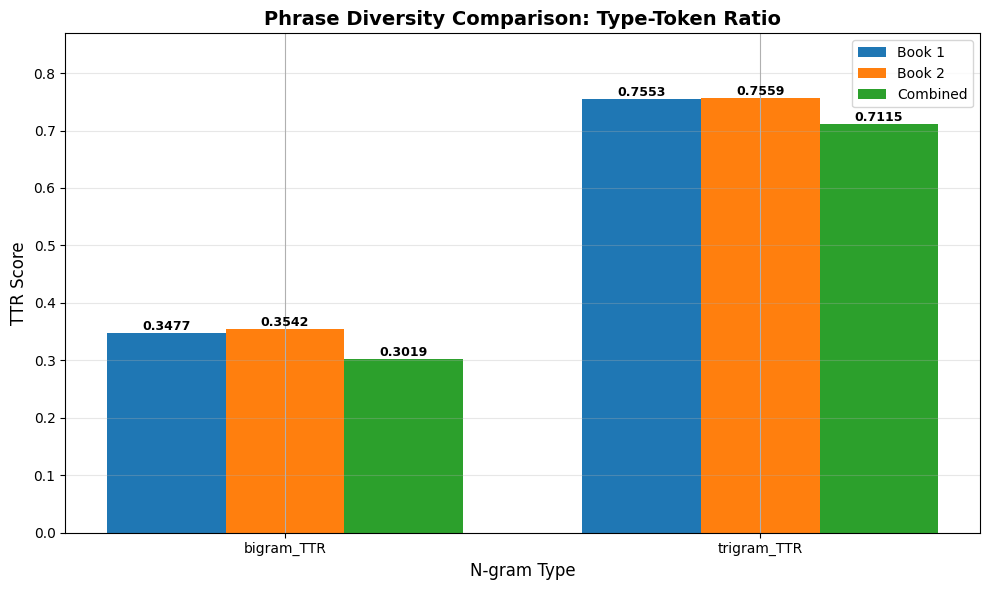

In [10]:
import numpy as np
fig_ttr, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(summary_df["metric"]))
width = 0.25
bars1 = ax.bar(x - width, summary_df["book1"], width, label='Book 1')
bars2 = ax.bar(x,           summary_df["book2"], width, label='Book 2')
bars3 = ax.bar(x + width,   summary_df["combined"], width, label='Combined')
ax.set_ylabel("TTR Score", fontsize=12)
ax.set_xlabel("N-gram Type", fontsize=12)
ax.set_title("Phrase Diversity Comparison: Type-Token Ratio", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(summary_df["metric"])
ax.legend(fontsize=10)
ax.set_ylim(0, float(summary_df[["book1", "book2", "combined"]].max().max()) * 1.15)
ax.grid(axis='y', alpha=0.3)
for bars in (bars1, bars2, bars3):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.tight_layout(); plt.show()


## 3. (Optional) Section-wise Diversity
If chapters/sections are detectable by regex, estimate diversity per section.

In [11]:
# Example scaffold (disabled by default):
# full_text = text1  # or text2
# sections = re.split(r"\bchapter\b|\bbook\b|\bpart\b", full_text, flags=re.IGNORECASE)
# rows = []
# for i, sec in enumerate(sections, start=1):
#     toks = WORD_RE.findall(sec.lower())
#     b2 = list(zip(toks, toks[1:]))
#     b3 = list(zip(toks, toks[1:], toks[2:]))
#     rows.append({"section": i, "bigram_TTR": ttr(b2), "trigram_TTR": ttr(b3)})
# sec_df = pd.DataFrame(rows)
# ax = sec_df.plot(x="section", y=["bigram_TTR","trigram_TTR"])
# ax.set_title("Phrase Diversity by Section (proxy)")
# ax.set_xlabel("Section index")
# ax.set_ylabel("TTR")
# plt.tight_layout(); plt.show()


## 4. Notes
- **Lower TTR** → more *formulaic/repetitive phrasing*.
- **Higher TTR** → more *varied phrasing* / lexical diversity.
- Section-wise analysis can reveal diversity shifts across the book.
- Removing stopwords may inflate TTR by dropping frequent function-word bigrams (e.g., “of the”, “in the”).

## 6. Export (tables/figures)

In [12]:
Path("results").mkdir(exist_ok=True)
summary_df.to_csv("results/TTR_table.csv", index=False)
try:
    fig_ttr.savefig("results/TTR_figure.png", dpi=200, bbox_inches="tight")
    print("\u2713 Saved TTR_table.csv and TTR_figure.png to results/")
except NameError:
    print("\u26A0 Figure not saved - run the visualization cell first")
    try:
        plt.savefig("results/TTR_figure.png", dpi=200, bbox_inches="tight")
    except Exception:
        pass


✓ Saved TTR_table.csv and TTR_figure.png to results/
